# Build Your First Neural Network with PyTorch

In this tutorial, you'll build your first Neural Network using PyTorch. You'll use it to predict whether or not is going to rain tomorrow using real weather information.

- [Run the complete notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1lDXVkdt7GC8jK_nGmOMKeDywXse-DY-u)
- [Read the Getting Things Done with Pytorch book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

You'll learn how to:

- Preprocess CSV files and convert the data to Tensors
- Build your own Neural Network model with PyTorch
- Use a loss function and an optimizer to train your model
- Evaluate your model and learn about the perils of imbalanced classification

In [0]:
!pip install -q -U watermark

In [0]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch

CPython 3.6.9
IPython 5.5.0

numpy 1.17.5
pandas 0.25.3
torch 1.4.0


In [0]:
# Heavily based on https://github.com/Prodicode/ann-visualizer

def ann_viz(model, view=True, filename="network.gv"):
    """Vizualizez a Sequential model.

    # Arguments
        model: A Keras model instance.

        view: whether to display the model after generation.

        filename: where to save the vizualization. (a .gv file)

        title: A title for the graph
    """
    from graphviz import Digraph

    input_layer = 0
    hidden_layers_nr = 0
    layer_types = []
    hidden_layers = []
    output_layer = 0
    layers = [layer for layer in model.modules() if type(layer) == torch.nn.Linear]

    for layer in layers:
        if layer == layers[0]:
            input_layer = layer.in_features
            hidden_layers_nr += 1
            if type(layer) == torch.nn.Linear:                
                hidden_layers.append(layer.out_features)
                layer_types.append("Dense")
            else:
                raise Exception("Input error")

        else:
            if layer == layers[-1]:
                output_layer = layer.out_features
            else:
                hidden_layers_nr += 1
                if type(layer) == torch.nn.Linear:

                    hidden_layers.append(layer.out_features)
                    layer_types.append("Dense")
                else:
                    raise Exception("Hidden error")
        last_layer_nodes = input_layer
        nodes_up = input_layer

    g = Digraph("g", filename=filename)
    n = 0
    g.graph_attr.update(splines="false", nodesep="0.5", ranksep="0", rankdir='LR')
    # Input Layer
    with g.subgraph(name="cluster_input") as c:
        if type(layers[0]) == torch.nn.Linear:
            the_label = "Input Layer"
            if layers[0].in_features > 10:
                the_label += " (+" + str(layers[0].in_features - 10) + ")"
                input_layer = 10
            c.attr(color="white")
            for i in range(0, input_layer):
                n += 1
                c.node(str(n))
                c.attr(labeljust="1")
                c.attr(label=the_label, labelloc="bottom")
                c.attr(rank="same")                
                c.node_attr.update(
                    width="0.65",
                    style="filled",                    
                    shape="circle",
                    color=HAPPY_COLORS_PALETTE[3],
                    fontcolor=HAPPY_COLORS_PALETTE[3],
                )
    for i in range(0, hidden_layers_nr):
        with g.subgraph(name="cluster_" + str(i + 1)) as c:
            if layer_types[i] == "Dense":
                c.attr(color="white")
                c.attr(rank="same")
                the_label = f'Hidden Layer {i + 1}'
                if layers[i].out_features > 10:
                    the_label += " (+" + str(layers[i].out_features - 10) + ")"
                    hidden_layers[i] = 10
                c.attr(labeljust="right", labelloc="b", label=the_label)
                for j in range(0, hidden_layers[i]):
                    n += 1
                    c.node(
                        str(n),
                        width="0.65",
                        shape="circle",
                        style="filled",
                        color=HAPPY_COLORS_PALETTE[0],
                        fontcolor=HAPPY_COLORS_PALETTE[0],
                    )
                    for h in range(nodes_up - last_layer_nodes + 1, nodes_up + 1):
                        g.edge(str(h), str(n))
                last_layer_nodes = hidden_layers[i]
                nodes_up += hidden_layers[i]
            else:
                raise Exception("Hidden layer type not supported")

    with g.subgraph(name="cluster_output") as c:
        if type(layers[-1]) == torch.nn.Linear:
            c.attr(color="white")
            c.attr(rank="same")
            c.attr(labeljust="1")
            for i in range(1, output_layer + 1):
                n += 1
                c.node(
                    str(n),
                    width="0.65",
                    shape="circle",
                    style="filled",
                    color=HAPPY_COLORS_PALETTE[4],
                    fontcolor=HAPPY_COLORS_PALETTE[4],
                    
                )
                for h in range(nodes_up - last_layer_nodes + 1, nodes_up + 1):
                    g.edge(str(h), str(n))
            c.attr(label="Output Layer", labelloc="bottom")
            c.node_attr.update(
                color="#2ecc71", style="filled", fontcolor="#2ecc71", shape="circle"
            )

    g.attr(arrowShape="none")
    g.edge_attr.update(arrowhead="none", color="#707070", penwidth="2")
    if view is True:
        g.view()

    return g


In [0]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from torch import nn, optim

import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Data

Our dataset contains daily weather information from multiple Australian weather stations. We're about to answer a simple question. *Will it rain tomorrow?*

The data is hosted on [Kaggle](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) and created by [Joe Young](https://www.kaggle.com/jsphyg). I've uploaded the dataset to Google Drive. Let's get it:

In [0]:
!gdown --id 1Q1wUptbNDYdfizk5abhmoFxIQiX19Tn7

Downloading...
From: https://drive.google.com/uc?id=1Q1wUptbNDYdfizk5abhmoFxIQiX19Tn7
To: /content/weatherAUS.csv
14.2MB [00:00, 38.9MB/s]


And load it into a data frame:

In [0]:
df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


We have a large set of features/columns here. You might also notice some *NaN*s. Let's have a look at the overall dataset size:

In [0]:
df.shape

(142193, 24)

Looks like we have plenty of data. But we got to do something about those missing values.

## Data Preprocessing

We'll start by simplifying the problem by removing most of the data. We'll use only 4 columns for predicting whether or not is going to rain tomorrow:

In [0]:
cols = ['Rainfall', 'Humidity3pm', 'Pressure9am', 'RainToday', 'RainTomorrow']

df = df[cols]

Neural Networks don't work with much else than numbers. We'll convert *yes* and *no* to 1 and 0, respectively:

In [0]:
df['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)

Let's drop the rows with missing values. There are better ways to do this, but we'll keep it simple:

In [0]:
df = df.dropna(how='any')
df.head()

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,0.0,0
1,0.0,25.0,1010.6,0.0,0
2,0.0,30.0,1007.6,0.0,0
3,0.0,16.0,1017.6,0.0,0
4,1.0,33.0,1010.8,0.0,0


Finally, we have a dataset we can work with. 

One important question we should answer is - *How balanced is our dataset?*. Or *How many times did it rain or not rain tomorrow?*:

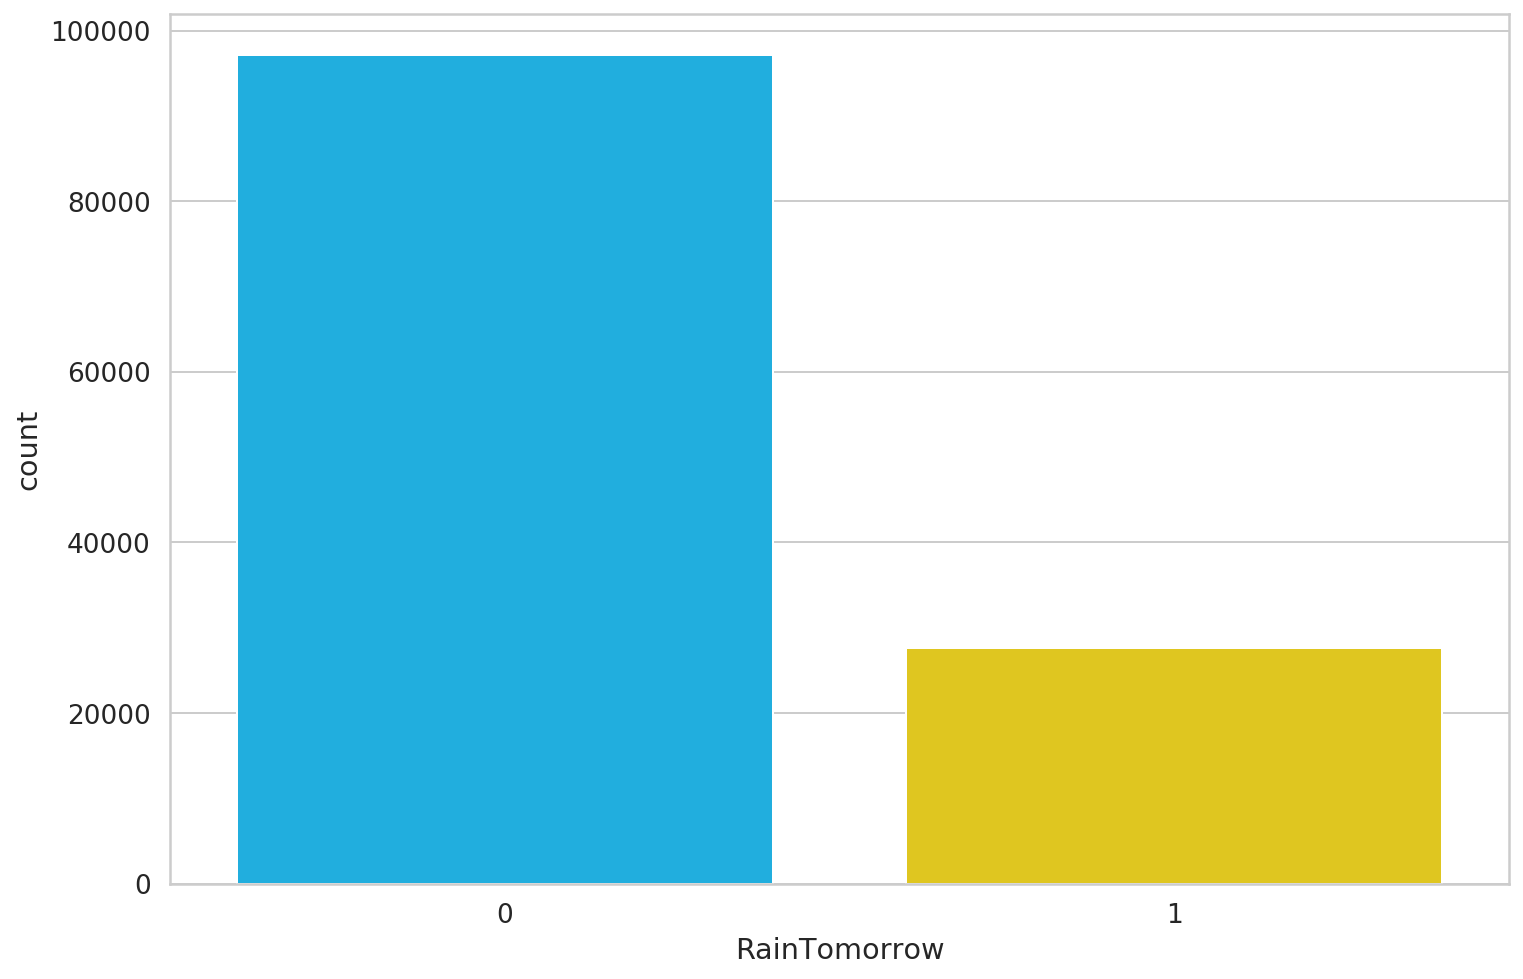

In [0]:
sns.countplot(df.RainTomorrow);

In [0]:
df.RainTomorrow.value_counts() / df.shape[0]

0    0.778762
1    0.221238
Name: RainTomorrow, dtype: float64

Things are not looking good. About 78% of the data points have a non-rainy day for tomorrow. This means that a model that predicts there will be no rain tomorrow will be correct about 78% of the time.

You can read and apply the [Practical Guide to Handling Imbalanced Datasets](https://www.curiousily.com/posts/practical-guide-to-handling-imbalanced-datasets/) if you want to mitigate this issue. Here, we'll just hope for the best.

The final step is to split the data into train and test sets:

In [0]:
X = df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']]
y = df[['RainTomorrow']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

And convert all of it to Tensors (so we can use it with PyTorch):

In [0]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())

X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([99751, 4]) torch.Size([99751])
torch.Size([24938, 4]) torch.Size([24938])


## Building a Neural Network

We'll build a simple Neural Network (NN) that tries to predicts will it rain tomorrow. 

Our input contains data from the four columns: `Rainfall, Humidity3pm, RainToday, Pressure9am`. We'll create an appropriate input layer for that.

The output will be a number between 0 and 1, representing how likely (our model thinks) it is going to rain tomorrow. The prediction will be given to us by the final (output) layer of the network. 

We'll two (hidden) layers between the input and output layers. The parameters (neurons) of those layer will decide the final output. All layers will be fully-connected.

One easy way to build the NN with PyTorch is to create a class that inherits from `torch.nn.Module`:


In [0]:
class Net(nn.Module):

  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 5)
    self.fc2 = nn.Linear(5, 3)
    self.fc3 = nn.Linear(3, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

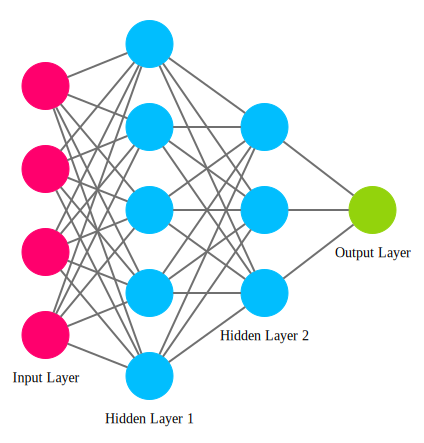

In [0]:
net = Net(X_train.shape[1])

ann_viz(net, view=False)

We start by creating the layers of our model in the constructor. The `forward()` method is where the magic happens. It accepts the input `x` and allows it to flow through each layer.

There is a corresponding backward pass (defined for you by PyTorch) that allows the model to learn from the errors that is currently making.

### Activation Functions

You might notice the calls to `F.relu` and `torch.sigmoid`. Why do we need those?

One of the cool *features* of Neural Networks is that they can approximate non-linear functions. In fact, [it is proven that they can approximate any function](https://en.wikipedia.org/wiki/Universal_approximation_theorem).

Good luck approximating non-linear functions by stacking linear layers. Activation functions allow you to break from the linear world and learn (hopefully) more. You'll usually find them applied to an output of some layer. 

Those functions must be hard to define, right?

#### ReLU

Not at all, let start with the ReLU definition (one of the most widely used activation function):

$$
\text{ReLU}(x) = \max({0, x})
$$

Easy peasy, the result is the maximum value of zero and the input.

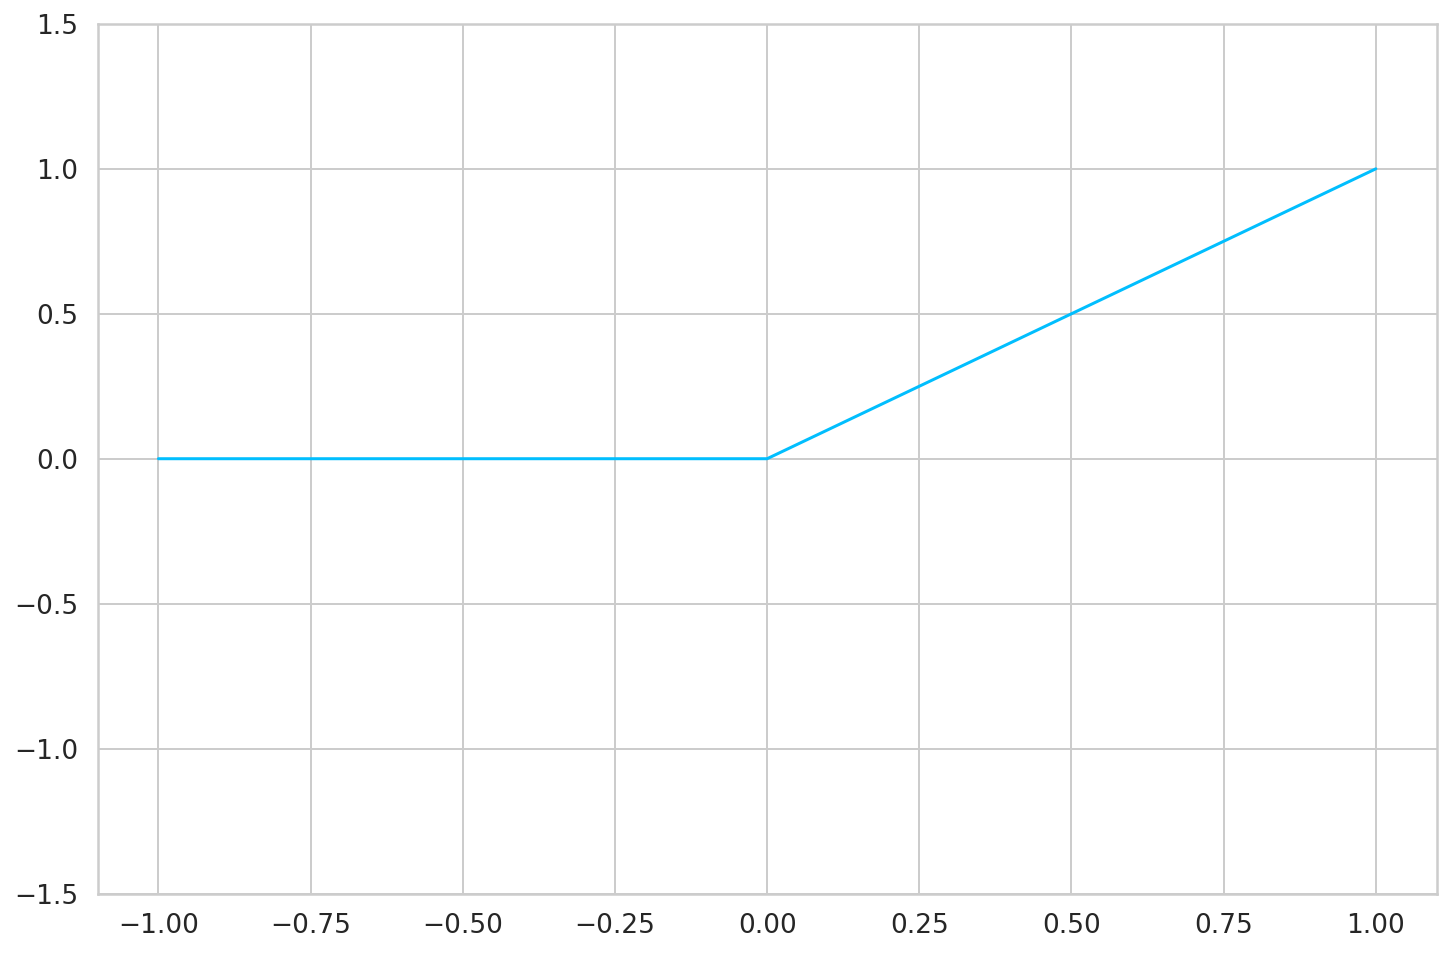

In [0]:
ax = plt.gca()

plt.plot(
  np.linspace(-1, 1, 5), 
  F.relu(torch.linspace(-1, 1, steps=5)).numpy()
)
ax.set_ylim([-1.5, 1.5]);

#### Sigmoid

The sigmoid is useful when you need to make a binary decision/classification (answering with a *yes* or a *no*). 

It is defined as:

$$\text{Sigmoid}(x) = \frac{1}{1+e^{-x}}$$

The sigmoid squishes the input values between 0 and 1. But in a super kind of way:

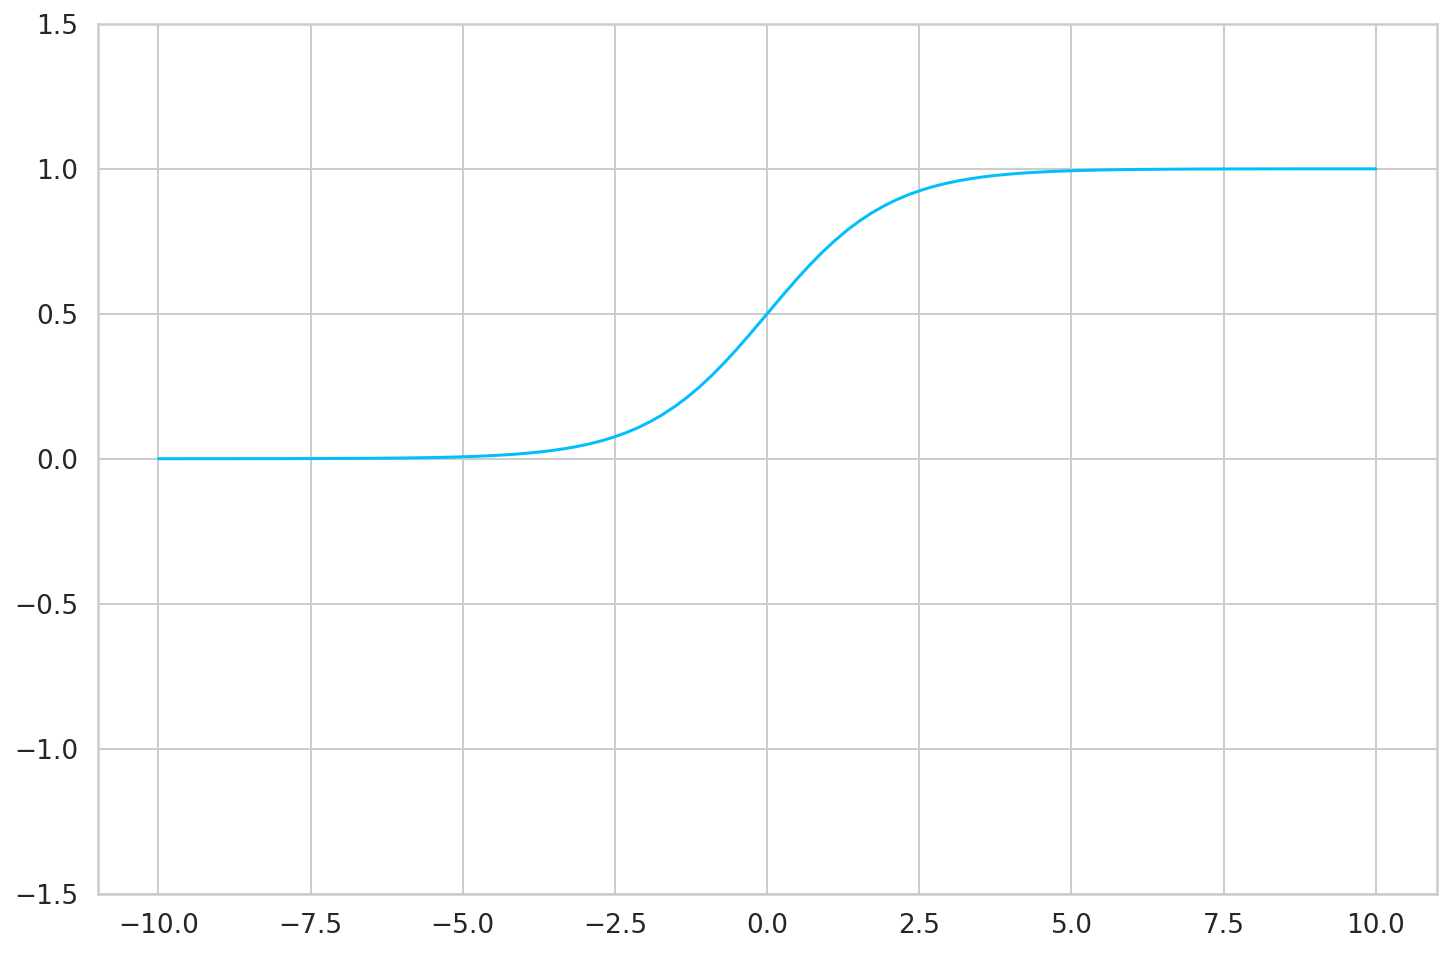

In [0]:
ax = plt.gca()

plt.plot(
  np.linspace(-10, 10, 100), 
  torch.sigmoid(torch.linspace(-10, 10, steps=100)).numpy()
)
ax.set_ylim([-1.5, 1.5]);

## Training

With the model in place, we need to find parameters that predict will it rain tomorrow. First, we need something to tell us how good we're currently doing:

In [0]:
criterion = nn.BCELoss()

The [BCELoss](https://pytorch.org/docs/stable/nn.html#bceloss) is a loss function that measures the difference between the two binary vectors. In our case, the predictions of our model and the real values. It expects the values to be outputed by the sigmoid function. The closer this value gets to 0, the better your model should be.

But how do we find parameters that minimize the loss function?

### Optimization

Imagine that each parameter of our NN is a knob. The optimizer's job is to find the perfect positions for each knob so that the loss gets close to 0. 

Real-world models can contain millions or even billions of parameters. With so many knobs to turn, it would be nice to have an efficient optimizer that quickly finds solutions.

Contrary to what you might believe, optimization in Deep Learning is just satisfying. In practice, you're content with good enough parameter values.

While there are tons of optimizers you can choose from, [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) is a safe first choice. PyTorch has a well-debugged implementation you can use:

In [0]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

Naturally, the optimizer requires the parameters. The second argument `lr` is *learning rate*. It is a tradeoff between how good parameters you're going to find and how fast you'll get there. Finding good values for this can be black magic and a lot of brute-force "experimentation".

### Doing it on the GPU

Doing massively parallel computations on GPUs is one of the enablers for modern Deep Learning. You'll need nVIDIA GPU for that.

PyTorch makes it really easy to transfer all the computation to your GPU:

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

In [0]:
net = net.to(device)

criterion = criterion.to(device)

We start by checking whether or not a CUDA device is available. Then, we transfer all training and test data to that device. Finally, we move our model and loss function.

### Finding Good Parameters

Having a loss function is great, but tracking the accuracy of our model is something easier to understand, for us mere mortals. Here's the definition for our accuracy:

In [0]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

We convert every value below 0.5 to 0. Otherwise, we set it to 1. Finally, we calculate the percentage of correct values.

With all the pieces of the puzzle in place, we can start training our model:

In [0]:
def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

for epoch in range(1000):
    
    y_pred = net(X_train)
    
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    
    if epoch % 100 == 0:
      train_acc = calculate_accuracy(y_train, y_pred)

      y_test_pred = net(X_test)
      y_test_pred = torch.squeeze(y_test_pred)

      test_loss = criterion(y_test_pred, y_test)

      test_acc = calculate_accuracy(y_test, y_test_pred)
      print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')
    
    optimizer.zero_grad()
    
    train_loss.backward()
    
    optimizer.step()

epoch 0
Train set - loss: 2.513, accuracy: 0.779
Test  set - loss: 2.517, accuracy: 0.778

epoch 100
Train set - loss: 0.457, accuracy: 0.792
Test  set - loss: 0.458, accuracy: 0.793

epoch 200
Train set - loss: 0.435, accuracy: 0.801
Test  set - loss: 0.436, accuracy: 0.8

epoch 300
Train set - loss: 0.421, accuracy: 0.814
Test  set - loss: 0.421, accuracy: 0.815

epoch 400
Train set - loss: 0.412, accuracy: 0.826
Test  set - loss: 0.413, accuracy: 0.827

epoch 500
Train set - loss: 0.408, accuracy: 0.831
Test  set - loss: 0.408, accuracy: 0.832

epoch 600
Train set - loss: 0.406, accuracy: 0.833
Test  set - loss: 0.406, accuracy: 0.835

epoch 700
Train set - loss: 0.405, accuracy: 0.834
Test  set - loss: 0.405, accuracy: 0.835

epoch 800
Train set - loss: 0.404, accuracy: 0.834
Test  set - loss: 0.404, accuracy: 0.835

epoch 900
Train set - loss: 0.404, accuracy: 0.834
Test  set - loss: 0.404, accuracy: 0.836



During the training, we show our model the data for `10,000` times. Each time we measure the loss, propagate the errors trough our model and asking the optimizer to find better parameters.

The `zero_grad()` method clears up the accumulated gradients, which the optimizer uses to find better parameters.

What about that accuracy? 83.6% accuracy on the test set sounds reasonable, right? Well, I am about to disappoint you. But first, let's learn how to save and load our trained models.

## Saving the model

Training a good model can take a lot of time. And I mean weeks, months or even years. So, let's make sure that you know how you can save your precious work. Saving is easy:

In [0]:
MODEL_PATH = 'model.pth'

torch.save(net, MODEL_PATH)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Restoring your model is easy too:

In [0]:
net = torch.load(MODEL_PATH)

## Evaluation

Wouldn't it be perfect to know what kinds of errors your model makes? Of course, that's impossible. But you can get an estimate.

Using just accuracy wouldn't be a good way to do it. Recall that our data contains mostly no rain examples.

One way to delve a bit deeper into your model performance is to assess the precision and recall for each class. In our case, that will be *no rain* and *rain*:

In [0]:
classes = ['No rain', 'Raining']

y_pred = net(X_test)

y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     No rain       0.85      0.96      0.90     19413
     Raining       0.74      0.40      0.52      5525

    accuracy                           0.84     24938
   macro avg       0.80      0.68      0.71     24938
weighted avg       0.83      0.84      0.82     24938



 A maximum precision of 1 indicates that the model is perfect at identifying only relevant examples. A maximum recall of 1 indicates that our model can find all relevant examples in the dataset for this class.

 You can see that our model is doing good when it comes to the *No rain* class. We have so many examples. Unfortunately, we can't really trust predictions of the *Raining* class.

 One of the best things about binary classification is that you can have a good look at a simple confusion matrix:

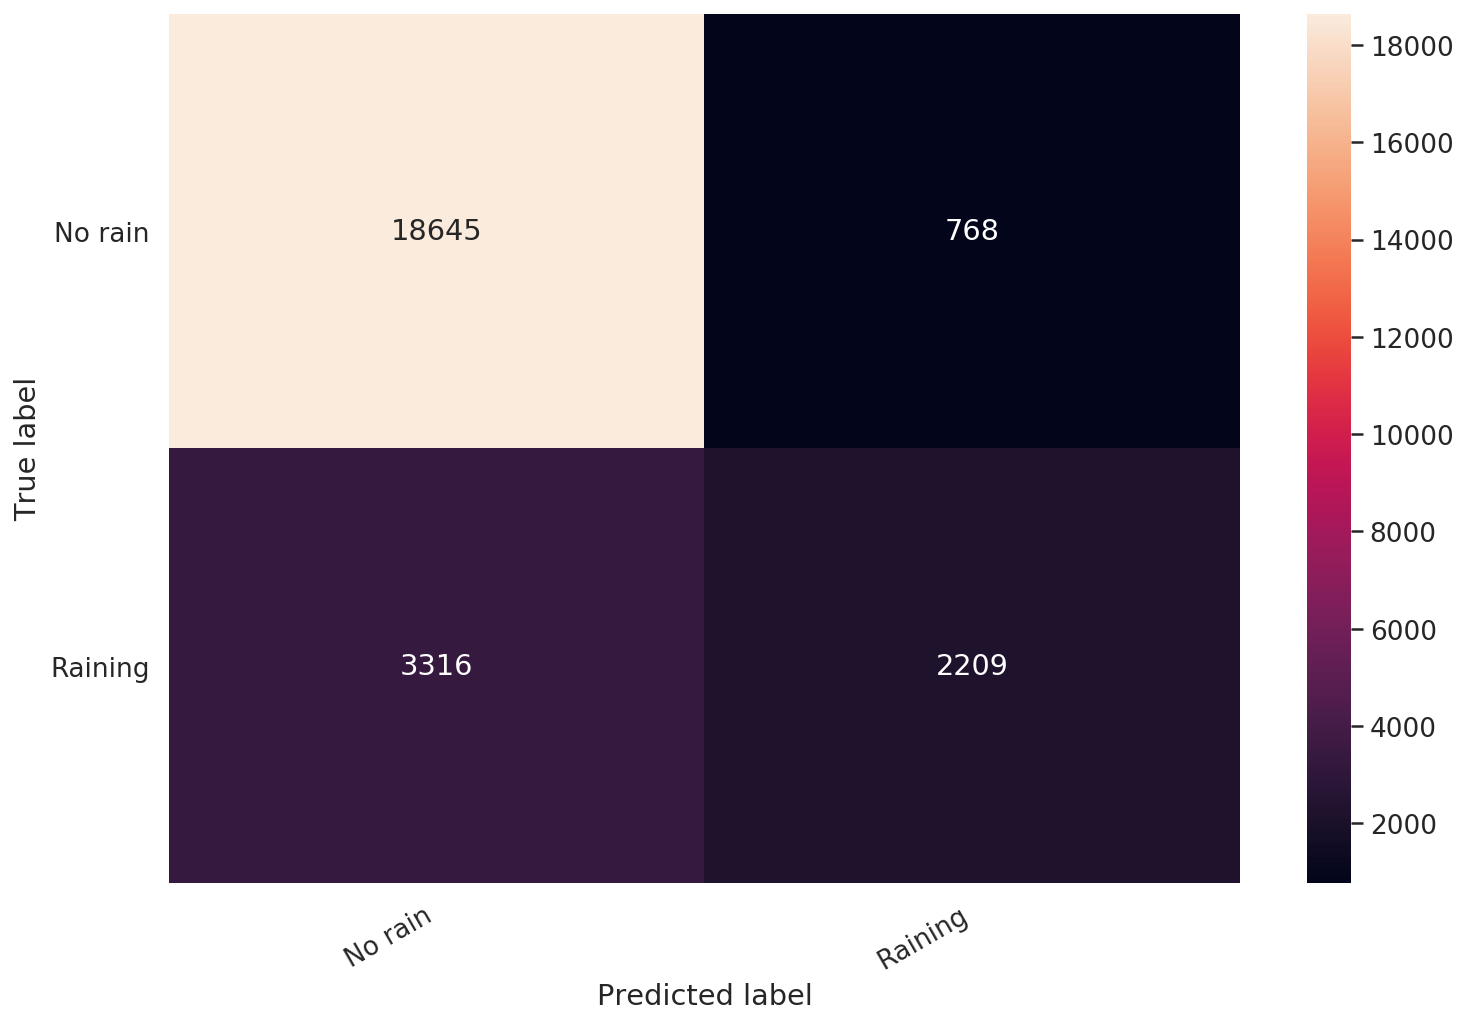

In [0]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

You can clearly see that our model shouldn't be trusted when it says it's going to rain.

## Conclusion

Well done! You now have a Neural Network that can predict the weather. Well, sort of. Building well-performing models is hard, really hard. But there are tricks you'll pick up along the way and (hopefully) get better at your craft!

- [Run the complete notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1lDXVkdt7GC8jK_nGmOMKeDywXse-DY-u)
- [Read the Getting Things Done with Pytorch book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

You learned how to:

- Preprocess CSV files and convert the data to Tensors
- Build your own Neural Network model with PyTorch
- Use a loss function and an optimizer to train your model
- Evaluate your model and learn about the perils of imbalanced classification

## References

- [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall)
- [Beyond Accuracy: Precision and Recall](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c)